In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fantasy-football/master_team_list.csv
/kaggle/input/fantasy-football/cleaned_merged_seasons.csv


## Data Loading and Cleaning

In this section, we load the Fantasy Premier League (FPL) dataset and perform the necessary cleaning steps to prepare it for analysis.  
Key operations include handling missing values, converting data types, and ensuring consistency across player, team, and fixture information.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2025-10-15 14:17:13.080004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760537833.278789      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760537833.331481      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/fantasy-football/cleaned_merged_seasons.csv')

/tmp/ipykernel_37/56455962.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/fantasy-football/cleaned_merged_seasons.csv')


In [4]:
df.head()

season_x                name position team_x  assists  bonus  bps  \
0  2016-17     Aaron Cresswell      DEF    NaN        0      0    0   
1  2016-17        Aaron Lennon      MID    NaN        0      0    6   
2  2016-17        Aaron Ramsey      MID    NaN        0      0    5   
3  2016-17  Abdoulaye Doucouré      MID    NaN        0      0    0   
4  2016-17        Adam Forshaw      MID    NaN        0      0    3   

   clean_sheets  creativity  element  ...  team_h_score  threat  total_points  \
0             0         0.0      454  ...           2.0     0.0             0   
1             0         0.3      142  ...           1.0     0.0             1   
2             0         4.9       16  ...           3.0    23.0             2   
3             0         0.0      482  ...           1.0     0.0             0   
4             0         1.3      286  ...           1.0     0.0             1   

   transfers_balance  transfers_in transfers_out  value  was_home  \
0                  0             0             0     55     False   
1                  0             0             0     60      True   
2                  0             0             0     80      True   
3                  0             0             0     50     False   
4                  0             0             0     45      True   

  yellow_cards  GW  
0            0   1  
1            0   1  
2            0   1  
3            0   1  
4            1   1  

[5 rows x 37 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96169 entries, 0 to 96168
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           96169 non-null  object 
 1   name               96169 non-null  object 
 2   position           96169 non-null  object 
 3   team_x             76317 non-null  object 
 4   assists            96169 non-null  int64  
 5   bonus              96169 non-null  int64  
 6   bps                96169 non-null  int64  
 7   clean_sheets       96169 non-null  int64  
 8   creativity         96169 non-null  float64
 9   element            96169 non-null  int64  
 10  fixture            96169 non-null  int64  
 11  goals_conceded     96169 non-null  int64  
 12  goals_scored       96169 non-null  int64  
 13  ict_index          96169 non-null  float64
 14  influence          96169 non-null  float64
 15  kickoff_time       96169 non-null  object 
 16  minutes            961

In [6]:
df.describe()

assists         bonus           bps  clean_sheets    creativity  \
count  96169.000000  96169.000000  96169.000000  96169.000000  96169.000000   
mean       0.041042      0.108715      6.080275      0.106739      4.734000   
std        0.215378      0.492334      9.850595      0.308783     10.689879   
min        0.000000      0.000000    -21.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000     10.000000      0.000000      2.400000   
max        4.000000      3.000000    128.000000      1.000000    170.900000   

            element       fixture  goals_conceded  goals_scored     ict_index  \
count  96169.000000  96169.000000    96169.000000  96169.000000  96169.000000   
mean     327.063264    198.413824        0.495887      0.045514      1.715793   
std      194.313766    108.884200        0.974269      0.233644      3.042551   
min        1.000000      1.000000        0.000000      0.000000      0.000000   
25%      159.000000    105.000000        0.000000      0.000000      0.000000   
50%      318.000000    203.000000        0.000000      0.000000      0.000000   
75%      486.000000    293.000000        1.000000      0.000000      2.500000   
max      778.000000    380.000000        9.000000      4.000000     32.800000   

       ...  team_a_score  team_h_score        threat  total_points  \
count  ...  96169.000000  96169.000000  96169.000000  96169.000000   
mean   ...      1.265158      1.516393      5.287598      1.379270   
std    ...      1.229086      1.349184     13.368420      2.542535   
min    ...      0.000000      0.000000      0.000000     -7.000000   
25%    ...      0.000000      1.000000      0.000000      0.000000   
50%    ...      1.000000      1.000000      0.000000      0.000000   
75%    ...      2.000000      2.000000      2.000000      2.000000   
max    ...      7.000000      9.000000    186.000000     29.000000   

       transfers_balance  transfers_in  transfers_out         value  \
count       9.616900e+04  9.616900e+04   9.616900e+04  96169.000000   
mean        1.677100e+03  1.454716e+04   1.286945e+04     51.352390   
std         6.581628e+04  5.725343e+04   4.840128e+04     12.667432   
min        -2.180978e+06  0.000000e+00   0.000000e+00     37.000000   
25%        -1.374000e+03  4.600000e+01   1.280000e+02     44.000000   
50%        -5.800000e+01  4.380000e+02   1.104000e+03     48.000000   
75%         7.900000e+01  5.042000e+03   7.562000e+03     54.000000   
max         1.983733e+06  2.104464e+06   2.233619e+06    133.000000   

       yellow_cards            GW  
count  96169.000000  96169.000000  
mean       0.053167     20.772099  
std        0.224367     10.941742  
min        0.000000      1.000000  
25%        0.000000     11.000000  
50%        0.000000     22.000000  
75%        0.000000     30.000000  
max        1.000000     38.000000  

[8 rows x 30 columns]

In [7]:
print(len(df[df['round']!=df['GW']]))

0


In [8]:
name_to_id_map = df.groupby('opp_team_name')['opponent_team'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else np.nan
).to_dict()

fixture_groups = df.groupby(['season_x', 'GW', 'fixture'])['opp_team_name'].unique()

fixture_df = fixture_groups.apply(lambda x: pd.Series(x[:2]))
fixture_df = fixture_df.rename(columns={0: 'team_1_name', 1: 'team_2_name'}).reset_index()

final_columns = [
    'season_x',
    'GW',
    'fixture',
    'team_1_name',
    'team_2_name',
    # 'team_1_id',
    # 'team_2_id'
]
fixture_df = fixture_df[final_columns]

In [9]:
fixture_df.head(20)

season_x  GW  fixture  team_1_name     team_2_name
0   2016-17   1        1      Swansea         Burnley
1   2016-17   1        2    West Brom  Crystal Palace
2   2016-17   1        3        Spurs         Everton
3   2016-17   1        4    Leicester            Hull
4   2016-17   1        5   Sunderland        Man City
5   2016-17   1        6        Stoke   Middlesbrough
6   2016-17   1        7  Southampton         Watford
7   2016-17   1        8    Liverpool         Arsenal
8   2016-17   1        9      Man Utd     Bournemouth
9   2016-17   1       10      Chelsea        West Ham
10  2016-17   2       11      Man Utd     Southampton
11  2016-17   2       12      Burnley       Liverpool
12  2016-17   2       13    Leicester         Arsenal
13  2016-17   2       14     Man City           Stoke
14  2016-17   2       15      Swansea            Hull
15  2016-17   2       16        Spurs  Crystal Palace
16  2016-17   2       17      Chelsea         Watford
17  2016-17   2       18    West Brom         Everton
18  2016-17   2       19   Sunderland   Middlesbrough
19  2016-17   2       20  Bournemouth        West Ham

In [10]:
df_merged = df.merge(
    fixture_df[['fixture', 'team_1_name', 'team_2_name', 'GW', 'season_x']],
    on=['fixture', 'GW', 'season_x'],
    how='left'
)
df_merged.head()

season_x                name position team_x  assists  bonus  bps  \
0  2016-17     Aaron Cresswell      DEF    NaN        0      0    0   
1  2016-17        Aaron Lennon      MID    NaN        0      0    6   
2  2016-17        Aaron Ramsey      MID    NaN        0      0    5   
3  2016-17  Abdoulaye Doucouré      MID    NaN        0      0    0   
4  2016-17        Adam Forshaw      MID    NaN        0      0    3   

   clean_sheets  creativity  element  ...  total_points  transfers_balance  \
0             0         0.0      454  ...             0                  0   
1             0         0.3      142  ...             1                  0   
2             0         4.9       16  ...             2                  0   
3             0         0.0      482  ...             0                  0   
4             0         1.3      286  ...             1                  0   

   transfers_in  transfers_out  value was_home  yellow_cards  GW  team_1_name  \
0             0              0     55    False             0   1      Chelsea   
1             0              0     60     True             0   1        Spurs   
2             0              0     80     True             0   1    Liverpool   
3             0              0     50    False             0   1  Southampton   
4             0              0     45     True             1   1        Stoke   

     team_2_name  
0       West Ham  
1        Everton  
2        Arsenal  
3        Watford  
4  Middlesbrough  

[5 rows x 39 columns]

In [11]:
# 2. Define the Conditional Fill Logic
def fill_missing_team_by_fixture(row):
    # If team_x is already present, return it.
    if pd.notna(row['team_x']):
        return row['team_x']

    # Identify the opponent name
    opponent = row['opp_team_name']

    # The missing team must be the non-opponent team among the two fixture teams (team_1_name and team_2_name)
    if row['team_1_name'] == opponent:
        # If team 1 is the opponent, the player's team is team 2
        return row['team_2_name']
    elif row['team_2_name'] == opponent:
        # If team 2 is the opponent, the player's team is team 1
        return row['team_1_name']
    else:
        # Fallback if names don't match
        return row['team_x']

In [12]:
# 3. Apply the fill logic
df_merged['team_x_fixed'] = df_merged.apply(fill_missing_team_by_fixture, axis=1)
# 4. Finalize the 'team_x' column by filling NaNs with the derived values
df_merged['team_x'] = df_merged['team_x'].fillna(df_merged['team_x_fixed'])

In [13]:
# 5. Clean up temporary columns and prepare final DataFrame
df_final = df_merged.drop(columns=['team_1_name', 'team_2_name', 'team_x_fixed'])

In [14]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96169 entries, 0 to 96168
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           96169 non-null  object 
 1   name               96169 non-null  object 
 2   position           96169 non-null  object 
 3   team_x             96169 non-null  object 
 4   assists            96169 non-null  int64  
 5   bonus              96169 non-null  int64  
 6   bps                96169 non-null  int64  
 7   clean_sheets       96169 non-null  int64  
 8   creativity         96169 non-null  float64
 9   element            96169 non-null  int64  
 10  fixture            96169 non-null  int64  
 11  goals_conceded     96169 non-null  int64  
 12  goals_scored       96169 non-null  int64  
 13  ict_index          96169 non-null  float64
 14  influence          96169 non-null  float64
 15  kickoff_time       96169 non-null  object 
 16  minutes            961

In [15]:
cleaned_df = df_final.drop(['round', 'bps', 'creativity', 'influence' ,'threat', 'kickoff_time'], axis=1)
cleaned_df.head(5)

season_x                name position         team_x  assists  bonus  \
0  2016-17     Aaron Cresswell      DEF       West Ham        0      0   
1  2016-17        Aaron Lennon      MID        Everton        0      0   
2  2016-17        Aaron Ramsey      MID        Arsenal        0      0   
3  2016-17  Abdoulaye Doucouré      MID        Watford        0      0   
4  2016-17        Adam Forshaw      MID  Middlesbrough        0      0   

   clean_sheets  element  fixture  goals_conceded  ...  team_a_score  \
0             0      454       10               0  ...           1.0   
1             0      142        3               0  ...           1.0   
2             0       16        8               3  ...           4.0   
3             0      482        7               0  ...           1.0   
4             0      286        6               1  ...           1.0   

   team_h_score  total_points  transfers_balance transfers_in  transfers_out  \
0           2.0             0                  0            0              0   
1           1.0             1                  0            0              0   
2           3.0             2                  0            0              0   
3           1.0             0                  0            0              0   
4           1.0             1                  0            0              0   

   value  was_home  yellow_cards  GW  
0     55     False             0   1  
1     60      True             0   1  
2     80      True             0   1  
3     50     False             0   1  
4     45      True             1   1  

[5 rows x 31 columns]

In [16]:
# Shows the actual duplicated rows
cleaned_df[cleaned_df.duplicated()]

Empty DataFrame
Columns: [season_x, name, position, team_x, assists, bonus, clean_sheets, element, fixture, goals_conceded, goals_scored, ict_index, minutes, opponent_team, opp_team_name, own_goals, penalties_missed, penalties_saved, red_cards, saves, selected, team_a_score, team_h_score, total_points, transfers_balance, transfers_in, transfers_out, value, was_home, yellow_cards, GW]
Index: []

[0 rows x 31 columns]

In [17]:
cleaned_df.rename(columns={
    'total_points': 'GW_points',
    'element': 'player_id',
}, inplace=True)
cleaned_df.head()

season_x                name position         team_x  assists  bonus  \
0  2016-17     Aaron Cresswell      DEF       West Ham        0      0   
1  2016-17        Aaron Lennon      MID        Everton        0      0   
2  2016-17        Aaron Ramsey      MID        Arsenal        0      0   
3  2016-17  Abdoulaye Doucouré      MID        Watford        0      0   
4  2016-17        Adam Forshaw      MID  Middlesbrough        0      0   

   clean_sheets  player_id  fixture  goals_conceded  ...  team_a_score  \
0             0        454       10               0  ...           1.0   
1             0        142        3               0  ...           1.0   
2             0         16        8               3  ...           4.0   
3             0        482        7               0  ...           1.0   
4             0        286        6               1  ...           1.0   

   team_h_score  GW_points  transfers_balance transfers_in  transfers_out  \
0           2.0          0                  0            0              0   
1           1.0          1                  0            0              0   
2           3.0          2                  0            0              0   
3           1.0          0                  0            0              0   
4           1.0          1                  0            0              0   

   value  was_home  yellow_cards  GW  
0     55     False             0   1  
1     60      True             0   1  
2     80      True             0   1  
3     50     False             0   1  
4     45      True             1   1  

[5 rows x 31 columns]

In [18]:
cleaned_df.rename(columns={
    'season_x': 'season',
    'team_x': 'team',
}, inplace=True)

In [19]:
cleaned_df['GW'] = cleaned_df['GW'].astype(int)
cleaned_df.sort_values(by=['season', 'player_id', 'GW'], inplace=True)
cleaned_df.head(10)

season             name position     team  assists  bonus  \
75    2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
2480  2016-17  Héctor Bellerín      DEF  Arsenal        0      3   
4816  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
7366  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
7579  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
7792  2016-17  Héctor Bellerín      DEF  Arsenal        1      2   
8005  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
8219  2016-17  Héctor Bellerín      DEF  Arsenal        1      0   
8434  2016-17  Héctor Bellerín      DEF  Arsenal        0      1   
280   2016-17  Héctor Bellerín      DEF  Arsenal        0      0   

      clean_sheets  player_id  fixture  goals_conceded  ...  team_a_score  \
75               0          6        8               4  ...           4.0   
2480             1          6       13               0  ...           0.0   
4816             0          6       28               1  ...           3.0   
7366             0          6       31               1  ...           1.0   
7579             0          6       43               1  ...           4.0   
7792             1          6       51               0  ...           0.0   
8005             1          6       61               0  ...           1.0   
8219             0          6       71               2  ...           2.0   
8434             1          6       81               0  ...           0.0   
280              0          6       97               1  ...           4.0   

      team_h_score  GW_points  transfers_balance transfers_in  transfers_out  \
75             3.0          0                  0            0              0   
2480           0.0          9             -56304         4952          61256   
4816           1.0          2             -14824        23529          38353   
7366           2.0          2             -22447        29018          51465   
7579           1.0          2             -34253         6258          40511   
7792           3.0         11             -64440         5049          69489   
8005           0.0          6              50025        63674          13649   
8219           3.0          4              15926        36844          20918   
8434           0.0          7              39161        50283          11122   
280            1.0          2              25971        31412           5441   

      value  was_home  yellow_cards  GW  
75       65      True             0   1  
2480     65     False             0   2  
4816     65     False             0   3  
7366     65      True             0   4  
7579     65     False             0   5  
7792     65      True             0   6  
8005     65     False             0   7  
8219     65      True             0   8  
8434     66      True             0   9  
280      66     False             0  10  

[10 rows x 31 columns]

In [20]:
cleaned_df['total_points'] = cleaned_df.groupby(['season', 'player_id'])['GW_points'].cumsum()

In [21]:
cleaned_df[cleaned_df['name'] == 'Héctor Bellerín']

season             name position     team  assists  bonus  \
75     2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
2480   2016-17  Héctor Bellerín      DEF  Arsenal        0      3   
4816   2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
7366   2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
7579   2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
...        ...              ...      ...      ...      ...    ...   
66182  2021-22  Héctor Bellerín      DEF  Arsenal        0      0   
66990  2021-22  Héctor Bellerín      DEF  Arsenal        0      0   
66991  2021-22  Héctor Bellerín      DEF  Arsenal        0      0   
68914  2021-22  Héctor Bellerín      DEF  Arsenal        0      0   
69013  2021-22  Héctor Bellerín      DEF  Arsenal        0      0   

       clean_sheets  player_id  fixture  goals_conceded  ...  team_h_score  \
75                0          6        8               4  ...           3.0   
2480              1          6       13               0  ...           0.0   
4816              0          6       28               1  ...           1.0   
7366              0          6       31               1  ...           2.0   
7579              0          6       43               1  ...           1.0   
...             ...        ...      ...             ...  ...           ...   
66182             0          9      349               0  ...           1.0   
66990             0          9      351               0  ...           2.0   
66991             0          9      218               0  ...           3.0   
68914             0          9      365               0  ...           2.0   
69013             0          9      371               0  ...           5.0   

       GW_points  transfers_balance  transfers_in transfers_out  value  \
75             0                  0             0             0     65   
2480           9             -56304          4952         61256     65   
4816           2             -14824         23529         38353     65   
7366           2             -22447         29018         51465     65   
7579           2             -34253          6258         40511     65   
...          ...                ...           ...           ...    ...   
66182          0                -17             0            17     48   
66990          0                -22             0            22     48   
66991          0                -22             0            22     48   
68914          0                -28             0            28     48   
69013          0                -13             0            13     48   

       was_home  yellow_cards  GW  total_points  
75         True             0   1             0  
2480      False             0   2             9  
4816      False             0   3            11  
7366       True             0   4            13  
7579      False             0   5            15  
...         ...           ...  ..           ...  
66182     False             0  35             0  
66990      True             0  36             0  
66991     False             0  36             0  
68914     False             0  37             0  
69013      True             0  38             0  

[152 rows x 32 columns]

In [22]:
cleaned_df.to_csv('cleaned_fpl.csv', index=False)

## Player Form and Points Overview

Here we explore player performance metrics such as **form** and **total points**.  
We analyze how these values are distributed across players and gameweeks, setting the foundation for identifying top performers during the 2022–23 season.

In [23]:
#adding the form column
cleaned_df['prev_total_points'] = cleaned_df.groupby(['season', 'player_id'])['GW_points'].shift(1)
cleaned_df['raw_form_score'] = cleaned_df.groupby(['season', 'player_id'])['prev_total_points'].rolling(
    window=4, 
    min_periods=1
).mean().reset_index(level=[0, 1], drop=True)

cleaned_df['form'] = cleaned_df['raw_form_score'].fillna(0) / 10
cleaned_df = cleaned_df.drop(columns=['prev_total_points', 'raw_form_score'])
cleaned_df.head(20)

season             name position     team  assists  bonus  \
75    2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
2480  2016-17  Héctor Bellerín      DEF  Arsenal        0      3   
4816  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
7366  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
7579  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
7792  2016-17  Héctor Bellerín      DEF  Arsenal        1      2   
8005  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
8219  2016-17  Héctor Bellerín      DEF  Arsenal        1      0   
8434  2016-17  Héctor Bellerín      DEF  Arsenal        0      1   
280   2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
498   2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
716   2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
935   2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
1154  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
1374  2016-17  Héctor Bellerín      DEF  Arsenal        1      1   
1595  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
1818  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
2043  2016-17  Héctor Bellerín      DEF  Arsenal        0      1   
2268  2016-17  Héctor Bellerín      DEF  Arsenal        0      2   
2692  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   

      clean_sheets  player_id  fixture  goals_conceded  ...  GW_points  \
75               0          6        8               4  ...          0   
2480             1          6       13               0  ...          9   
4816             0          6       28               1  ...          2   
7366             0          6       31               1  ...          2   
7579             0          6       43               1  ...          2   
7792             1          6       51               0  ...         11   
8005             1          6       61               0  ...          6   
8219             0          6       71               2  ...          4   
8434             1          6       81               0  ...          7   
280              0          6       97               1  ...          2   
498              0          6      101               1  ...          2   
716              0          6      113               0  ...          0   
935              0          6      121               0  ...          0   
1154             0          6      140               0  ...          0   
1374             0          6      141               1  ...          6   
1595             0          6      156               2  ...          1   
1818             0          6      164               2  ...          1   
2043             1          6      171               0  ...          7   
2268             1          6      181               0  ...          8   
2692             0          6      191               3  ...          0   

      transfers_balance  transfers_in  transfers_out value  was_home  \
75                    0             0              0    65      True   
2480             -56304          4952          61256    65     False   
4816             -14824         23529          38353    65     False   
7366             -22447         29018          51465    65      True   
7579             -34253          6258          40511    65     False   
7792             -64440          5049          69489    65      True   
8005              50025         63674          13649    65     False   
8219              15926         36844          20918    65      True   
8434              39161         50283          11122    66      True   
280               25971         31412           5441    66     False   
498              -78964          7475          86439    66      True   
716             -196153          6905         203058    65     False   
935             -114277           373         114650    65      True   
1154           

In [24]:
cleaned_df[cleaned_df['season']=='2017-18']

season             name position       team  assists  bonus  \
8671   2017-18  Héctor Bellerín      DEF    Arsenal        0      0   
11861  2017-18  Héctor Bellerín      DEF    Arsenal        0      0   
15170  2017-18  Héctor Bellerín      DEF    Arsenal        0      0   
18265  2017-18  Héctor Bellerín      DEF    Arsenal        0      0   
18545  2017-18  Héctor Bellerín      DEF    Arsenal        0      0   
...        ...              ...      ...        ...      ...    ...   
17138  2017-18    Harvey Barnes      MID  Leicester        0      0   
17535  2017-18    Harvey Barnes      MID  Leicester        0      0   
17536  2017-18    Harvey Barnes      MID  Leicester        0      0   
17966  2017-18    Harvey Barnes      MID  Leicester        0      0   
17933  2017-18    Dwight McNeil      MID    Burnley        0      0   

       clean_sheets  player_id  fixture  goals_conceded  ...  GW_points  \
8671              0          7        1               3  ...          1   
11861             0          7       16               1  ...          2   
15170             0          7       28               4  ...          0   
18265             1          7       31               0  ...          6   
18545             1          7       49               0  ...          5   
...             ...        ...      ...             ...  ...        ...   
17138             0        642      352               0  ...          0   
17535             0        642      366               0  ...          0   
17536             0        642      304               0  ...          1   
17966             0        642      379               0  ...          1   
17933             0        646      371               0  ...          1   

       transfers_balance  transfers_in  transfers_out value  was_home  \
8671                   0             0              0    60      True   
11861             -28590         14368          42958    60     False   
15170             -67892          7781          75673    60     False   
18265             -59067         13066          72133    59      True   
18545             -30945          3865          34810    59     False   
...                  ...           ...            ...   ...       ...   
17138                 18            29             11    45     False   
17535                 13            24             11    45      True   
17536                 13            24             11    45      True   
17966                 18            26              8    45     False   
17933                  0             0              0    45      True   

       yellow_cards  GW  total_points      form  
8671              0   1             1  0.000000  
11861             0   2             3  0.100000  
15170             0   3             3  0.150000  
18265             0   4             9  0.100000  
18545             1   5            14  0.225000  
...             ...  ..           ...       ...  
17138             0  36             1  0.050000  
17535             0  37             1  0.033333  
17536             0  37             2  0.025000  
17966             0  38             3  0.050000  
17933             0  38             1  0.000000  

[11285 rows x 33 columns]

## Position-Based Performance Analysis

This section examines how different player positions — Goalkeepers (GK), Defenders (DEF), Midfielders (MID), and Forwards (FWD) — perform across seasons.  
We visualize both **total points** and **average points per position**, highlighting trends and shifts in performance over time.


In [25]:
# position_map = {
#     'GKP': 0,
#     'GK': 0,
#     'DEF': 1,
#     'MID': 2,
#     'FWD': 3
# }

was_home_map = {
    True: 1,
    False: 0
}

In [26]:
# cleaned_df['position'] = cleaned_df['position'].map(position_map)
cleaned_df['was_home'] = cleaned_df['was_home'].map(was_home_map)

In [27]:
cleaned_df.head()

season             name position     team  assists  bonus  \
75    2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
2480  2016-17  Héctor Bellerín      DEF  Arsenal        0      3   
4816  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
7366  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
7579  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   

      clean_sheets  player_id  fixture  goals_conceded  ...  GW_points  \
75               0          6        8               4  ...          0   
2480             1          6       13               0  ...          9   
4816             0          6       28               1  ...          2   
7366             0          6       31               1  ...          2   
7579             0          6       43               1  ...          2   

      transfers_balance  transfers_in  transfers_out value  was_home  \
75                    0             0              0    65         1   
2480             -56304          4952          61256    65         0   
4816             -14824         23529          38353    65         0   
7366             -22447         29018          51465    65         1   
7579             -34253          6258          40511    65         0   

      yellow_cards  GW  total_points      form  
75               0   1             0  0.000000  
2480             0   2             9  0.000000  
4816             0   3            11  0.450000  
7366             0   4            13  0.366667  
7579             0   5            15  0.325000  

[5 rows x 33 columns]

In [28]:
cleaned_df['position'] = cleaned_df['position'].replace('GKP', 'GK')
print(cleaned_df['position'].value_counts())

position
MID    39163
DEF    33683
FWD    12669
GK     10654
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

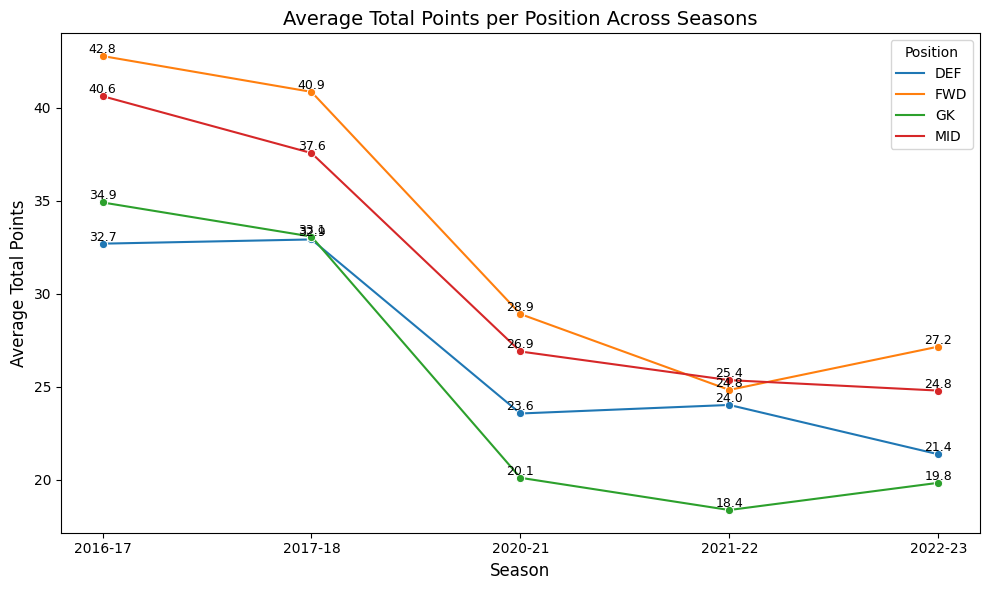

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

position_points = (
    cleaned_df.groupby(['season', 'position'])['total_points']
      .sum()
      .reset_index()
)

avg_points_per_season = (
    cleaned_df.groupby(['season', 'position'])['total_points']
      .mean()
      .reset_index()
)

plt.figure(figsize=(10,6))
ax = sns.lineplot(
    data=avg_points_per_season,
    x='season',
    y='total_points',
    hue='position',
    marker='o'
)

for position in avg_points_per_season['position'].unique():
    subset = avg_points_per_season[avg_points_per_season['position'] == position]
    for x, y in zip(subset['season'], subset['total_points']):
        ax.text(x, y, f"{y:.1f}", fontsize=9, ha='center', va='bottom')

plt.title('Average Total Points per Position Across Seasons', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Total Points', fontsize=12)
plt.legend(title='Position')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

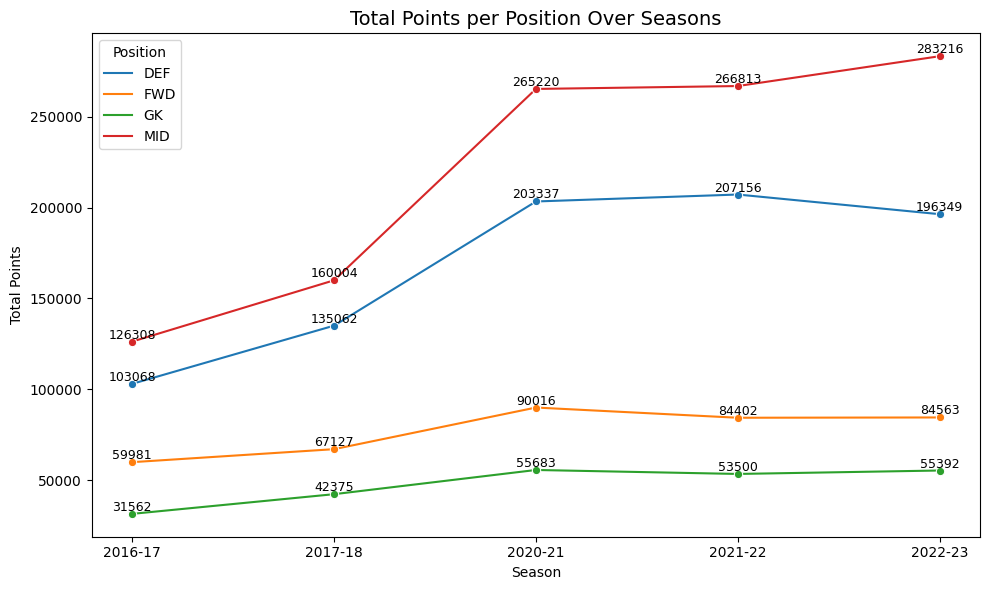

In [30]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(
    data=position_points,
    x='season',
    y='total_points',
    hue='position',
    marker='o'
)

for position in position_points['position'].unique():
    subset = position_points[position_points['position'] == position]
    for x, y in zip(subset['season'], subset['total_points']):
        ax.text(x, y, f"{y:.0f}", fontsize=9, ha='center', va='bottom')

plt.title('Total Points per Position Over Seasons', fontsize=14)
plt.xlabel('Season')
plt.ylabel('Total Points')
plt.legend(title='Position')
plt.tight_layout()
plt.show()

## Top Player Evolution During 2022–23 Season

Here, we focus on the top five players who achieved the **highest form** and **highest points** in the 2022–23 FPL season.  
We track their performance progression across gameweeks to observe form fluctuations and identify consistent performers.

In [31]:
season_df = cleaned_df[cleaned_df['season'] == '2022-23'].copy()
season_df['form'] = pd.to_numeric(season_df['form'], errors='coerce')
top_forms_df = (
    season_df.groupby('name', as_index=False)['form']
    .max()
    .sort_values('form', ascending=False)
    .reset_index(drop=True)
)

top_forms_df.head(10)

name      form
0         Fabian Schär  1.500000
1          Pascal Groß  1.500000
2       Erling Haaland  1.375000
3  Aleksandar Mitrović  1.300000
4     Dejan Kulusevski  1.300000
5      Kevin De Bruyne  1.225000
6        Mohamed Salah  1.200000
7          Lloyd Kelly  1.200000
8  Oleksandr Zinchenko  1.200000
9       Rodrigo Moreno  1.166667

In [32]:
top_players = (
    season_df.groupby('name')['form'].max()
    .reset_index()
    .sort_values('form', ascending=False)
    .drop_duplicates(subset=['name'])
    .head(5)
)

top_players_df = season_df[season_df['name'].isin(top_players['name'])]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

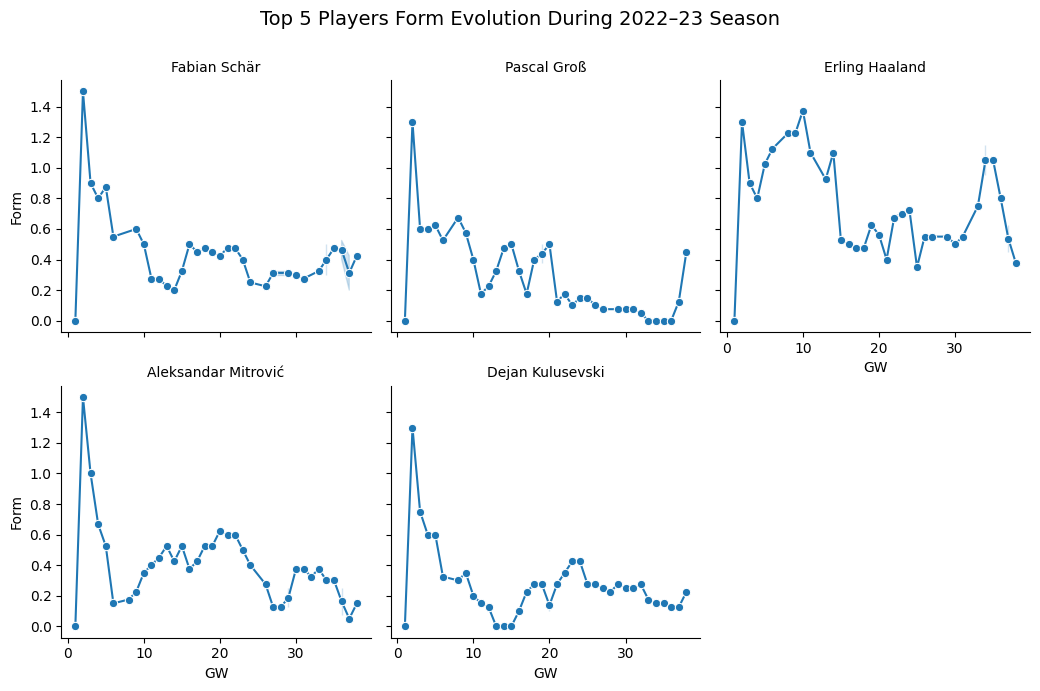

In [33]:
g = sns.FacetGrid(
    top_players_df,
    col='name',
    col_wrap=3,
    height=3.5,
    sharey=True,
    sharex=True
)
g.map_dataframe(sns.lineplot, x='GW', y='form', marker='o', color='#1f77b4')

for ax, name in zip(g.axes.flat, top_players['name']):
    player_data = top_players_df[top_players_df['name'] == name]
    # for x, y in zip(player_data['GW'], player_data['form']):
    #     ax.text(x, y, f"{y:.1f}", fontsize=7, ha='center', va='bottom')
    ax.set_title(name, fontsize=10)
    ax.set_xlabel("GW")
    ax.set_ylabel("Form")

plt.subplots_adjust(top=0.88)
g.fig.suptitle('Top 5 Players Form Evolution During 2022–23 Season', fontsize=14)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

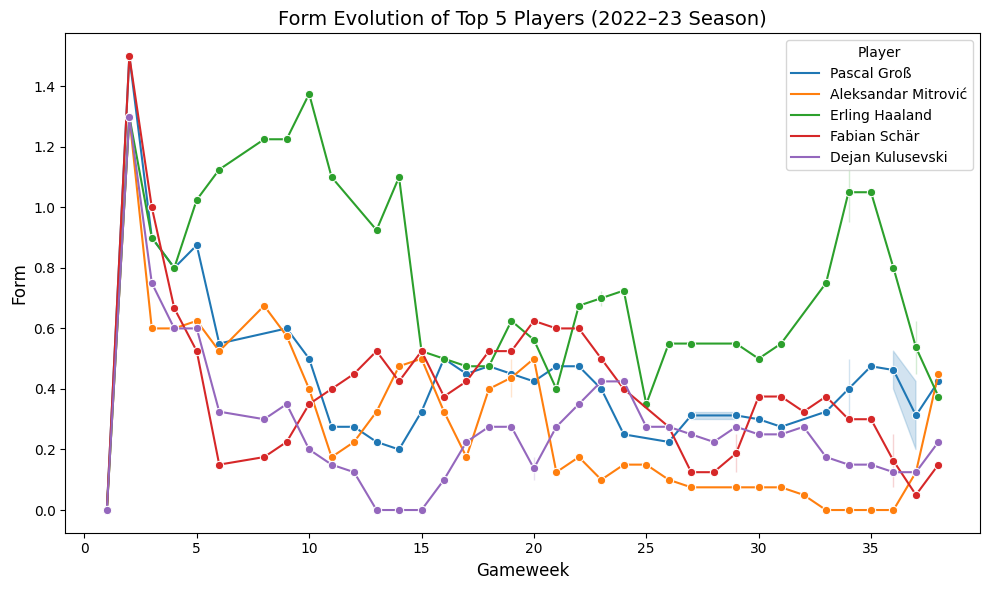

In [34]:
# Plot form evolution
plt.figure(figsize=(10,6))
ax = sns.lineplot(
    data=top_players_df,
    x='GW',
    y='form',
    hue='name',
    marker='o'
)


plt.title('Form Evolution of Top 5 Players (2022–23 Season)', fontsize=14)
plt.xlabel('Gameweek', fontsize=12)
plt.ylabel('Form', fontsize=12)
plt.legend(title='Player')
plt.tight_layout()
plt.show()


In [35]:
season_df['total_points'] = pd.to_numeric(season_df['total_points'], errors='coerce')

# DataFrame of each player's highest total points (no duplicates)
top_points_df = (
    season_df.groupby('name', as_index=False)['total_points']
    .max()
    .sort_values('total_points', ascending=False)
    .reset_index(drop=True)
)

top_points_df.head(10)

name  total_points
0            Erling Haaland           272
1                Harry Kane           263
2             Mohamed Salah           239
3           Martin Ødegaard           212
4           Marcus Rashford           205
5               Bukayo Saka           202
6           Kieran Trippier           198
7  Gabriel Martinelli Silva           198
8           Kevin De Bruyne           183
9                Ivan Toney           182

In [36]:
# Top 5 players based on their highest total points
top_players = (
    season_df.groupby('name')['total_points'].max()
    .reset_index()
    .sort_values('total_points', ascending=False)
    .drop_duplicates(subset=['name'])
    .head(5)
)

# Filter data for these top 5 players
top_players_df = season_df[season_df['name'].isin(top_players['name'])]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

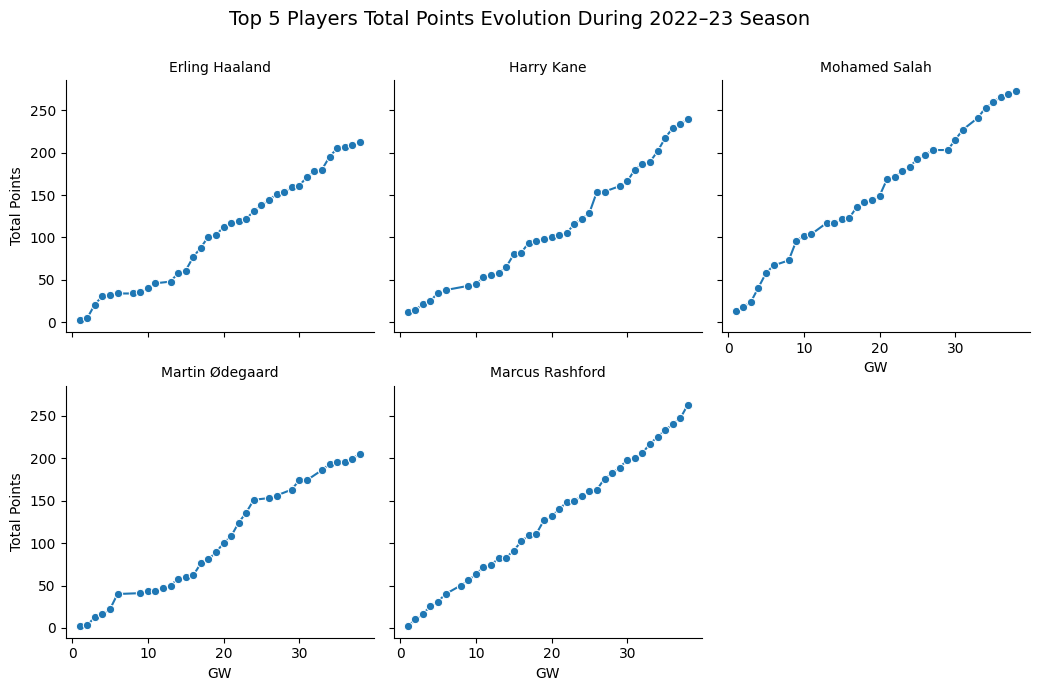

In [37]:
# FacetGrid: one subplot per player
g = sns.FacetGrid(
    top_players_df,
    col='name',
    col_wrap=3,
    height=3.5,
    sharey=True,
    sharex=True
)
g.map_dataframe(sns.lineplot, x='GW', y='total_points', marker='o', color='#1f77b4')

for ax, name in zip(g.axes.flat, top_players['name']):
    ax.set_title(name, fontsize=10)
    ax.set_xlabel("GW")
    ax.set_ylabel("Total Points")

plt.subplots_adjust(top=0.88)
g.fig.suptitle('Top 5 Players Total Points Evolution During 2022–23 Season', fontsize=14)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

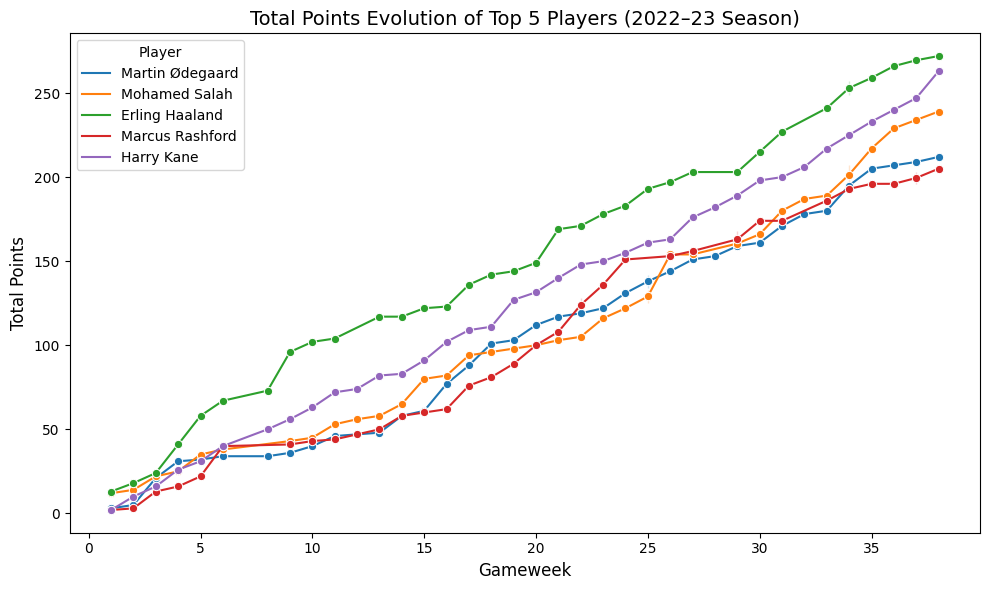

In [38]:
# Combined plot for all top 5 players
plt.figure(figsize=(10,6))
sns.lineplot(
    data=top_players_df,
    x='GW',
    y='total_points',
    hue='name',
    marker='o'
)

plt.title('Total Points Evolution of Top 5 Players (2022–23 Season)', fontsize=14)
plt.xlabel('Gameweek', fontsize=12)
plt.ylabel('Total Points', fontsize=12)
plt.legend(title='Player')
plt.tight_layout()
plt.show()

## Comparing Top Players by Form vs Total Points

This section investigates whether players with the **highest form** also rank among those with the **highest total points**.  
A Venn diagram visually compares the top 5 players in each category, revealing overlaps and differences between short-term form and cumulative performance.

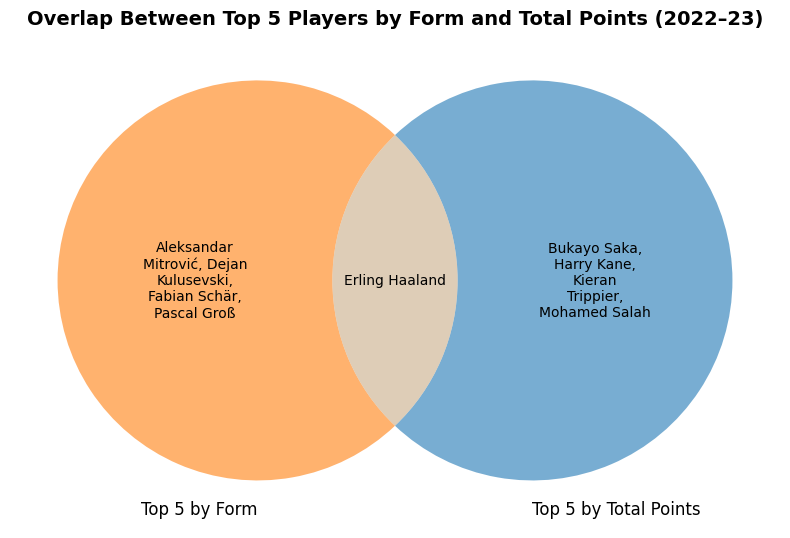

In [39]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import textwrap

# Define sets
form_set = set(top_forms_df.head(5)['name'])
points_set = set(
    season_df.groupby('name', as_index=False)['total_points']
    .sum()
    .sort_values('total_points', ascending=False)
    .drop_duplicates(subset=['name'])
    .head(5)['name']
)

# Helper function for wrapping names dynamically
def wrap_names(names, width=15):
    return "\n".join(textwrap.wrap(", ".join(sorted(names)), width=width))

# Plot Venn diagram
plt.figure(figsize=(8,7))
v = venn2(
    [form_set, points_set],
    set_labels=('Top 5 by Form', 'Top 5 by Total Points'),
    set_colors=("#FF7F0E", "#1F77B4"),
    alpha=0.6
)

# Add wrapped player names dynamically
if v.get_label_by_id('10'):
    v.get_label_by_id('10').set_text(wrap_names(form_set - points_set))
if v.get_label_by_id('01'):
    v.get_label_by_id('01').set_text(wrap_names(points_set - form_set))
if v.get_label_by_id('11'):
    v.get_label_by_id('11').set_text(wrap_names(form_set & points_set))

# Title and style
plt.title('Overlap Between Top 5 Players by Form and Total Points (2022–23)', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


## Feature Engineering
### Computing Fixture Difficulties

In [40]:
difficulty_df = cleaned_df.copy()

unique_team_fixtures = difficulty_df.drop_duplicates(subset=['season','GW', 'fixture', 'team'])[
    ['season', 'GW', 'fixture', 'team', 'was_home', 'team_h_score', 'team_a_score']
].copy()


unique_team_fixtures['team_goals_scored'] = unique_team_fixtures.apply(
    lambda r: r['team_h_score'] if r['was_home'] else r['team_a_score'],
    axis=1
)
unique_team_fixtures['team_goals_conceded'] = unique_team_fixtures.apply(
    lambda r: r['team_a_score'] if r['was_home'] else r['team_h_score'],
    axis=1
)

team_weekly = (
    unique_team_fixtures
    .groupby(['season', 'GW', 'team'], as_index=False)
    .agg({'team_goals_scored': 'sum', 'team_goals_conceded': 'sum'})
)


team_weekly = team_weekly.sort_values(['season', 'team', 'GW']).reset_index(drop=True)


team_weekly['cum_goals_scored'] = team_weekly.groupby(['season', 'team'])['team_goals_scored'].cumsum()
team_weekly['cum_goals_conceded'] = team_weekly.groupby(['season', 'team'])['team_goals_conceded'].cumsum()


df_cumulative = team_weekly.rename(columns={'GW': 'gw',
                                           'cum_goals_scored': 'goals_scored',
                                           'cum_goals_conceded': 'goals_conceded'})[
    ['season', 'gw', 'team', 'goals_conceded', 'goals_scored']
].copy()

print(df_cumulative.head())


    season  gw     team  goals_conceded  goals_scored
0  2016-17   1  Arsenal             4.0           3.0
1  2016-17   2  Arsenal             4.0           3.0
2  2016-17   3  Arsenal             5.0           6.0
3  2016-17   4  Arsenal             6.0           8.0
4  2016-17   5  Arsenal             7.0          12.0


In [41]:
# Ensure proper sorting
df_cumulative = df_cumulative.sort_values(['season', 'team', 'gw']).reset_index(drop=True)

# Step 1: Compute per-GW (not cumulative) goals scored and conceded differences
# You already have cumulative totals, so let's compute the per-GW goals:
df_cumulative['goals_scored_gw'] = (
    df_cumulative.groupby(['season', 'team'])['goals_scored'].diff().fillna(df_cumulative['goals_scored'])
)
df_cumulative['goals_conceded_gw'] = (
    df_cumulative.groupby(['season', 'team'])['goals_conceded'].diff().fillna(df_cumulative['goals_conceded'])
)

# Step 2: Compute rolling averages for the last 8 GWs
df_cumulative['attack_power'] = (
    df_cumulative.groupby(['season', 'team'])['goals_scored_gw']
    .transform(lambda x: x.rolling(window=8, min_periods=1).mean())
)

df_cumulative['defensive_power'] = (
    df_cumulative.groupby(['season', 'team'])['goals_conceded_gw']
    .transform(lambda x: x.rolling(window=8, min_periods=1).mean())
)

# Step 3: Optionally shift by 1 GW to avoid data leakage (predict next GW using past GWs)
df_cumulative['attack_power'] = (
    df_cumulative.groupby(['season', 'team'])['attack_power'].shift(1)
)
df_cumulative['defensive_power'] = (
    df_cumulative.groupby(['season', 'team'])['defensive_power'].shift(1)
)

# # Step 4: Clean up (optional)
# df_cumulative = df_cumulative.drop(columns=['goals_scored_gw', 'goals_conceded_gw'])

# Step 5: Preview
df_cumulative.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


season  gw     team  goals_conceded  goals_scored  goals_scored_gw  \
0  2016-17   1  Arsenal             4.0           3.0              3.0   
1  2016-17   2  Arsenal             4.0           3.0              0.0   
2  2016-17   3  Arsenal             5.0           6.0              3.0   
3  2016-17   4  Arsenal             6.0           8.0              2.0   
4  2016-17   5  Arsenal             7.0          12.0              4.0   

   goals_conceded_gw  attack_power  defensive_power  
0                4.0           NaN              NaN  
1                0.0           3.0         4.000000  
2                1.0           1.5         2.000000  
3                1.0           2.0         1.666667  
4                1.0           2.0         1.500000

In [42]:
# Step 2: Merge attack/defense power for both team and opponent
team_power = df_cumulative[['season', 'gw', 'team', 'attack_power', 'defensive_power']]

team_power=team_power.rename(columns={'gw':'GW'})

# Merge onto player-level data or fixture-level data
df_merged = cleaned_df.merge(team_power, on=['season', 'GW', 'team'], how='left', suffixes=('', '_team'))

# Now also merge opponent power (match by opponent_team)
df_merged = df_merged.merge(
    team_power.rename(columns={'team': 'opp_team_name',
                               'attack_power': 'opp_attack_power',
                               'defensive_power': 'opp_defensive_power'}),
    on=['season', 'GW', 'opp_team_name'],
    how='left'
)

# Step 3: Compute fixture difficulty
# Idea: harder if opponent’s defense is strong and your attack is weak
df_merged['offensive_fixture_difficulty'] = df_merged['opp_defensive_power'] - df_merged['attack_power']

# Step 4: Optionally compute opponent difficulty for defense (how strong their attack is)
df_merged['defensive_fixture_difficulty'] = df_merged['opp_attack_power'] - df_merged['defensive_power']

df_merged['fixture_difficulty']=(df_merged['offensive_fixture_difficulty']+df_merged['defensive_fixture_difficulty'])/2

df_merged[['team', 'opp_team_name', 'fixture_difficulty', 'defensive_fixture_difficulty','offensive_fixture_difficulty']].head(10)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


team  opp_team_name  fixture_difficulty  defensive_fixture_difficulty  \
0  Arsenal      Liverpool                 NaN                           NaN   
1  Arsenal      Leicester           -2.000000                     -3.000000   
2  Arsenal        Watford           -0.500000                     -1.000000   
3  Arsenal    Southampton           -0.833333                     -1.000000   
4  Arsenal           Hull           -0.750000                     -0.250000   
5  Arsenal        Chelsea           -0.300000                      0.600000   
6  Arsenal        Burnley           -0.750000                     -0.333333   
7  Arsenal        Swansea           -0.357143                     -0.142857   
8  Arsenal  Middlesbrough           -0.625000                     -0.250000   
9  Arsenal     Sunderland           -0.125000                      0.000000   

   offensive_fixture_difficulty  
0                           NaN  
1                     -1.000000  
2                      0.000000  
3                     -0.666667  
4                     -1.250000  
5                     -1.200000  
6                     -1.166667  
7                     -0.571429  
8                     -1.000000  
9                     -0.250000

In [43]:
df_merged['fixture_difficulty'].describe()

count    93938.000000
mean        -0.003393
std          0.545284
min         -3.000000
25%         -0.375000
50%          0.000000
75%          0.375000
max          3.000000
Name: fixture_difficulty, dtype: float64

In [44]:
# Cap extreme values just in case
df_merged['fixture_difficulty'] = df_merged['fixture_difficulty'].clip(-3, 3)

# Define bins and labels
bins = [-3, -0.75, 0.0, 0.75, 3.0]
labels = [0, 1, 2, 3]  # 3 = most difficult

df_merged['fixture_difficulty_cat'] = pd.cut(
    df_merged['fixture_difficulty'], bins=bins, labels=labels, include_lowest=True
)

print(df_merged['fixture_difficulty_cat'].value_counts().sort_index())

fixture_difficulty_cat
0     8014
1    41385
2    38227
3     6312
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


In [45]:
cleaned_df['fixture_difficulty']=df_merged['fixture_difficulty_cat'].copy()

In [46]:
cleaned_df.sort_values(['season','GW'])
cleaned_df.head()

season             name position     team  assists  bonus  \
75    2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
2480  2016-17  Héctor Bellerín      DEF  Arsenal        0      3   
4816  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
7366  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   
7579  2016-17  Héctor Bellerín      DEF  Arsenal        0      0   

      clean_sheets  player_id  fixture  goals_conceded  ...  \
75               0          6        8               4  ...   
2480             1          6       13               0  ...   
4816             0          6       28               1  ...   
7366             0          6       31               1  ...   
7579             0          6       43               1  ...   

      transfers_balance  transfers_in  transfers_out  value was_home  \
75                    0             0              0     65        1   
2480             -56304          4952          61256     65        0   
4816             -14824         23529          38353     65        0   
7366             -22447         29018          51465     65        1   
7579             -34253          6258          40511     65        0   

      yellow_cards  GW  total_points      form  fixture_difficulty  
75               0   1             0  0.000000                   1  
2480             0   2             9  0.000000                   1  
4816             0   3            11  0.450000                   1  
7366             0   4            13  0.366667                   1  
7579             0   5            15  0.325000                   2  

[5 rows x 34 columns]

In [47]:
# df_merged.to_csv('dfm.csv', index=False)

In [48]:
cleaned_df=df_merged.copy()
cleaned_df = cleaned_df.drop(['attack_power', 'defensive_power', 'opp_attack_power', 'opp_defensive_power', 'offensive_fixture_difficulty', 'defensive_fixture_difficulty', 'fixture_difficulty'], axis=1)
cleaned_df = cleaned_df.rename(columns={'fixture_difficulty_cat': 'fixture_difficulty'})


In [49]:
cleaned_df['fixture_difficulty'] = cleaned_df['fixture_difficulty'].fillna(1)
cleaned_df['fixture_difficulty'] = pd.to_numeric(cleaned_df['fixture_difficulty'], errors='coerce')

In [50]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96169 entries, 0 to 96168
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   season              96169 non-null  object 
 1   name                96169 non-null  object 
 2   position            96169 non-null  object 
 3   team                96169 non-null  object 
 4   assists             96169 non-null  int64  
 5   bonus               96169 non-null  int64  
 6   clean_sheets        96169 non-null  int64  
 7   player_id           96169 non-null  int64  
 8   fixture             96169 non-null  int64  
 9   goals_conceded      96169 non-null  int64  
 10  goals_scored        96169 non-null  int64  
 11  ict_index           96169 non-null  float64
 12  minutes             96169 non-null  int64  
 13  opponent_team       96169 non-null  int64  
 14  opp_team_name       96169 non-null  object 
 15  own_goals           96169 non-null  int64  
 16  pena

In [51]:
cleaned_df["upcoming_fixture_difficulty"] = (
    cleaned_df.groupby(["player_id", "season"])["fixture_difficulty"]
    .shift(-1)
)

In [52]:
cleaned_df["is_upcoming_home"] = (
    cleaned_df.groupby(["player_id", "season"])["was_home"]
    .shift(-1)
)

### Handle blank gameweeks

In [53]:
cleaned_df = cleaned_df.sort_values(["player_id", "season", "GW"]).reset_index(drop=True)

complete_gws = (
    cleaned_df.groupby(["player_id", "season"])
    .apply(lambda x: pd.DataFrame({"GW": range(1, 39)}))
    .reset_index(level=[0, 1])
)

/tmp/ipykernel_37/310777470.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.DataFrame({"GW": range(1, 39)}))


In [54]:
cleaned_df = pd.merge(
    complete_gws,
    cleaned_df,
    on=["player_id", "season", "GW"],
    how="left"
)

In [55]:
static_cols = ["name", "position", "team", "opponent_team", "opp_team_name"]
for col in static_cols:
    if col in cleaned_df.columns:
        cleaned_df[col] = cleaned_df.groupby(["player_id", "season"])[col].ffill().bfill()

# Step 3: Mark missing GWs (player didn’t play)
cleaned_df["blank_gw"] = (cleaned_df["GW_points"].isna()).astype(int)


form_cols = [
    "assists", "bonus", "clean_sheets", "goals_conceded",
    "goals_scored", "ict_index", "minutes", "own_goals",
    "penalties_missed", "penalties_saved", "red_cards", "saves",
    "yellow_cards", "GW_points", "total_points", "form","value",
    "selected", "is_upcoming_home", "upcoming_fixture_difficulty"
]
for col in form_cols:
    if col in cleaned_df.columns:
        cleaned_df[col] = cleaned_df.groupby(["player_id", "season"])[col].ffill().fillna(0)

structural_cols = [
    "fixture", "team_a_score", "team_h_score",
    "transfers_balance", "transfers_in", "transfers_out",
    "was_home", "fixture_difficulty",
]
for col in structural_cols:
    if col in cleaned_df.columns:
        # use 0 for numeric, NaN for string-like
        if cleaned_df[col].dtype.kind in "biufc":
            cleaned_df[col] = cleaned_df[col].fillna(0)
        else:
            cleaned_df[col] = cleaned_df[col].fillna("Unknown")

In [56]:
if not any(col.startswith('position_') for col in cleaned_df.columns):
    position_dummies = pd.get_dummies(cleaned_df['position'], prefix='position', dtype=int)
    cleaned_df = pd.concat([cleaned_df, position_dummies], axis=1)
cleaned_df.head()

player_id   season  GW        name position     team  assists  bonus  \
0          1  2020-21   1  Mesut Özil      MID  Arsenal      0.0    0.0   
1          1  2020-21   2  Mesut Özil      MID  Arsenal      0.0    0.0   
2          1  2020-21   3  Mesut Özil      MID  Arsenal      0.0    0.0   
3          1  2020-21   4  Mesut Özil      MID  Arsenal      0.0    0.0   
4          1  2020-21   5  Mesut Özil      MID  Arsenal      0.0    0.0   

   clean_sheets  fixture  ...  total_points  form  fixture_difficulty  \
0           0.0      2.0  ...           0.0   0.0                 1.0   
1           0.0      9.0  ...           0.0   0.0                 1.0   
2           0.0     23.0  ...           0.0   0.0                 2.0   
3           0.0     29.0  ...           0.0   0.0                 0.0   
4           0.0     44.0  ...           0.0   0.0                 2.0   

   upcoming_fixture_difficulty  is_upcoming_home blank_gw  position_DEF  \
0                          1.0               1.0        0             0   
1                          2.0               0.0        0             0   
2                          0.0               1.0        0             0   
3                          2.0               0.0        0             0   
4                          2.0               1.0        0             0   

   position_FWD  position_GK  position_MID  
0             0            0             1  
1             0            0             1  
2             0            0             1  
3             0            0             1  
4             0            0             1  

[5 rows x 41 columns]

In [57]:
all_teams = pd.concat([cleaned_df['team'], cleaned_df['opp_team_name']]).unique()
print(all_teams)

['Arsenal' 'Fulham' 'West Brom' 'Aston Villa' 'Middlesbrough' 'Everton'
 'Bournemouth' 'Crystal Palace' 'Liverpool' 'Newcastle' 'Southampton'
 'Chelsea' 'West Ham' 'Man City' 'Brighton' 'Burnley' 'Brentford'
 'Watford' 'Stoke' 'Man Utd' 'Norwich' 'Hull' 'Huddersfield' 'Leicester'
 'Leeds' 'Sheffield Utd' "Nott'm Forest" 'Sunderland' 'Swansea' 'Spurs'
 'Wolves']


In [58]:
encoder = LabelEncoder()
encoder.fit(all_teams)

# Transform both columns using the same encoder
cleaned_df['team_no'] = encoder.transform(cleaned_df['team'])
cleaned_df['opp_team_no'] = encoder.transform(cleaned_df['opp_team_name'])
cleaned_df.head()

player_id   season  GW        name position     team  assists  bonus  \
0          1  2020-21   1  Mesut Özil      MID  Arsenal      0.0    0.0   
1          1  2020-21   2  Mesut Özil      MID  Arsenal      0.0    0.0   
2          1  2020-21   3  Mesut Özil      MID  Arsenal      0.0    0.0   
3          1  2020-21   4  Mesut Özil      MID  Arsenal      0.0    0.0   
4          1  2020-21   5  Mesut Özil      MID  Arsenal      0.0    0.0   

   clean_sheets  fixture  ...  fixture_difficulty  \
0           0.0      2.0  ...                 1.0   
1           0.0      9.0  ...                 1.0   
2           0.0     23.0  ...                 2.0   
3           0.0     29.0  ...                 0.0   
4           0.0     44.0  ...                 2.0   

   upcoming_fixture_difficulty  is_upcoming_home  blank_gw  position_DEF  \
0                          1.0               1.0         0             0   
1                          2.0               0.0         0             0   
2                          0.0               1.0         0             0   
3                          2.0               0.0         0             0   
4                          2.0               1.0         0             0   

  position_FWD  position_GK  position_MID  team_no  opp_team_no  
0            0            0             1        0            9  
1            0            0             1        0           29  
2            0            0             1        0           14  
3            0            0             1        0           21  
4            0            0             1        0           15  

[5 rows x 43 columns]

In [59]:
cleaned_df["upcoming_blank"] = (
    cleaned_df.groupby(["player_id", "season"])["blank_gw"]
    .shift(-1)
    .fillna(0)
    .astype(int)
)

In [75]:
cleaned_df["upcoming_total_points"] = (
    cleaned_df.groupby(["player_id", "season"])["GW_points"]
    .shift(-1)
)

In [76]:
cleaned_df.loc[cleaned_df['upcoming_blank'] == 1, 'upcoming_total_points'] = 0

In [77]:
# --- 8️⃣ Re-sort for consistency ---
cleaned_df = cleaned_df.sort_values(["season","player_id","GW"]).reset_index(drop=True)

In [78]:
cleaned_df.head()

player_id   season  GW             name position     team  assists  bonus  \
0          6  2016-17   1  Héctor Bellerín      DEF  Arsenal      0.0    0.0   
1          6  2016-17   2  Héctor Bellerín      DEF  Arsenal      0.0    3.0   
2          6  2016-17   3  Héctor Bellerín      DEF  Arsenal      0.0    0.0   
3          6  2016-17   4  Héctor Bellerín      DEF  Arsenal      0.0    0.0   
4          6  2016-17   5  Héctor Bellerín      DEF  Arsenal      0.0    0.0   

   clean_sheets  fixture  ...  is_upcoming_home  blank_gw  position_DEF  \
0           0.0      8.0  ...               0.0         0             1   
1           1.0     13.0  ...               0.0         0             1   
2           0.0     28.0  ...               1.0         0             1   
3           0.0     31.0  ...               0.0         0             1   
4           0.0     43.0  ...               1.0         0             1   

   position_FWD  position_GK position_MID  team_no  opp_team_no  \
0             0            0            0        0           14   
1             0            0            0        0           13   
2             0            0            0        0           27   
3             0            0            0        0           22   
4             0            0            0        0           11   

   upcoming_blank  upcoming_total_points  
0               0                    9.0  
1               0                    2.0  
2               0                    2.0  
3               0                    2.0  
4               0                   11.0  

[5 rows x 45 columns]

In [100]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111697 entries, 0 to 111696
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   player_id                    111697 non-null  int64  
 1   season                       111697 non-null  object 
 2   GW                           111697 non-null  int64  
 3   name                         111697 non-null  object 
 4   position                     111697 non-null  object 
 5   team                         111697 non-null  object 
 6   assists                      111697 non-null  float64
 7   bonus                        111697 non-null  float64
 8   clean_sheets                 111697 non-null  float64
 9   fixture                      111697 non-null  float64
 10  goals_conceded               111697 non-null  float64
 11  goals_scored                 111697 non-null  float64
 12  ict_index                    111697 non-null  float64
 13 

In [65]:
cleaned_df.to_csv('cleaned_fpl_test.csv', index=False)

In [66]:
# Count appearances per player per GW
dgws = cleaned_df.groupby(['player_id', 'GW','season']).size().reset_index(name='appearances')

# Filter where appearances > 1
double_gameweeks = dgws[dgws['appearances'] > 1]
double_gameweeks.head()

player_id  GW   season  appearances
76           1  26  2021-22            2
85           1  29  2021-22            2
97           1  33  2021-22            2
101          1  34  2022-23            2
102          1  35  2020-21            2

In [67]:
cleaned_df.corr(numeric_only=True)

player_id        GW   assists     bonus  \
player_id                     1.000000 -0.002609 -0.067337 -0.080920   
GW                           -0.002609  1.000000  0.002297  0.003711   
assists                      -0.067337  0.002297  1.000000  0.297375   
bonus                        -0.080920  0.003711  0.297375  1.000000   
clean_sheets                 -0.128062 -0.000964  0.134652  0.293855   
fixture                      -0.118218  0.840912  0.017232  0.018873   
goals_conceded               -0.151187  0.003720  0.113870  0.051832   
goals_scored                 -0.072116  0.003155  0.124961  0.611707   
ict_index                    -0.200619 -0.008131  0.413592  0.533471   
minutes                      -0.257245  0.006442  0.228745  0.296055   
opponent_team                -0.042027 -0.000234  0.012553  0.012338   
own_goals                    -0.016171 -0.002465  0.005718 -0.000467   
penalties_missed             -0.014179  0.001308  0.014851  0.009496   
penalties_saved              -0.008117  0.002071 -0.004602  0.104097   
red_cards                    -0.010706 -0.002437  0.003791 -0.005479   
saves                        -0.054373  0.002579 -0.024339  0.124192   
selected                     -0.164203  0.027241  0.142761  0.185390   
team_a_score                 -0.135320  0.077379  0.081671  0.015121   
team_h_score                 -0.137596  0.070627  0.093275  0.018672   
GW_points                    -0.184757  0.006663  0.455313  0.749062   
transfers_balance            -0.001095  0.014776  0.057654  0.069389   
transfers_in                 -0.093075 -0.027407  0.129674  0.150786   
transfers_out                -0.108562 -0.052382  0.075307  0.084390   
value                        -0.458949  0.153128  0.169639  0.170881   
was_home                     -0.129252  0.061024  0.031447  0.037238   
yellow_cards                 -0.077014 -0.006727  0.053549  0.032951   
total_points                 -0.278758  0.400110  0.191174  0.241617   
form                         -0.249084  0.037688  0.183933  0.226924   
fixture_difficulty           -0.214942  0.119443  0.014013  0.015336   
upcoming_fixture_difficulty  -0.238845  0.120421 -0.000733  0.029557   
is_upcoming_home             -0.135673  0.068083  0.010924  0.010939   
blank_gw                      0.370141 -0.173290 -0.046351 -0.051424   
position_DEF                 -0.040852  0.000222 -0.048334 -0.009549   
position_FWD                  0.011820 -0.000457  0.030024  0.048208   
position_GK                   0.048516  0.000399 -0.062626 -0.008102   
position_MID                  0.000191 -0.000155  0.066003 -0.018819   
team_no                       0.392129 -0.002981 -0.004547 -0.005473   
opp_team_no                  -0.054289 -0.001478  0.017749  0.018821   
upcoming_blank                0.356675 -0.177383 -0.043671 -0.048260   
upcoming_total_points        -0.173816 -0.019391  0.148453  0.179719   

                             clean_sheets   fixture  goals_conceded  \
player_id                       -0.128062 -0.118218       -0.151187   
GW                              -0.000964  0.840912        0.003720   
assists                          0.134652  0.017232        0.113870   
bonus                            0.293855  0.018873        0.051832   
clean_sheets                     1.000000  0.015913       -0.157424   
fixture                          0.015913  1.000000        0.049079   
goals_conceded                  -0.157424  0.049079        1.000000   
goals_scored                     0.132680  0.018755        0.119997   
ict_index                        0.368403  0.036687        0.380664   
minutes                          0.470435  0.065900        0.626406   
opponent_team                    0.018541  0.016252       -0.018671   
own_goals                       -0.012464  0.002808        0.079048   
penalties_missed                 0.010083  0.006294        0.026104   
penalties_saved                  0.012947  0.004745        0.030511   
red_cards  

## Model Training
Training and evaluating various models

In [110]:
valid_target_mask = ~(cleaned_df['GW']==38)

In [111]:
# feature_cols = ["season","position","team","assists","bonus","clean_sheets","player_id","goals_conceded","goals_scored", "assists", "minutes", "clean_sheets", "ict_index", "opp_team_name", "own_goals","penalties_missed","penalties_saved","red_cards", "saves", "GW_points", "value", "was_home","yellow_cards", "total_points","form"]
# feature_cols = ["ict_index","minutes","goals_conceded", "selected", "GW_points", "value","total_points","form"]
feature_cols = ["form","ict_index","minutes","total_points", "GW_points", "value","fixture_difficulty", "position_DEF", "position_FWD", "position_GK", "position_MID", "upcoming_fixture_difficulty", "is_upcoming_home", "upcoming_blank"]

X = cleaned_df.loc[valid_target_mask, feature_cols]
y = cleaned_df.loc[valid_target_mask, "upcoming_total_points"]

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
# Step 5: Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = y_scaler.transform(np.array(y_test).reshape(-1, 1))

### Random Forest

In [117]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)

In [118]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("🌲 Random Forest Regressor Results:")
print(f"MAE: {mae_rf:.3f}")
print(f"MSE: {mse_rf:.3f}")
print(f"RMSE: {rmse_rf:.3f}")
print(f"R²: {r2_rf:.3f}")

🌲 Random Forest Regressor Results:
MAE: 1.088
MSE: 4.280
RMSE: 2.069
R²: 0.280


In [137]:
import joblib

joblib.dump(rf, "random_forest_model_compressed.pkl", compress=9)
print("✅ Compressed model saved as 'random_forest_model_compressed.pkl'")


✅ Compressed model saved as 'random_forest_model_compressed.pkl'


### Feed-Forward Neural Network

In [119]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras.layers import BatchNormalization

In [120]:
model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dense(1)  # Regression output
    ])
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1760540046.525237      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [121]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

In [122]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100


I0000 00:00:1760540053.554911     112 service.cc:148] XLA service 0x7c2f74014ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760540053.555373     112 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760540053.967643     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


  64/2723 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.0279 - mae: 1.3084  

I0000 00:00:1760540056.267878     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2723/2723 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 4.4065 - mae: 1.1825 - val_loss: 4.0800 - val_mae: 1.0318 - learning_rate: 0.0010
Epoch 2/100
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.0568 - mae: 1.0767 - val_loss: 4.0739 - val_mae: 1.0582 - learning_rate: 0.0010
Epoch 3/100
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.1034 - mae: 1.0821 - val_loss: 4.0593 - val_mae: 1.0348 - learning_rate: 0.0010
Epoch 4/100
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.1430 - mae: 1.0871 - val_loss: 4.0578 - val_mae: 1.0086 - learning_rate: 0.0010
Epoch 5/100
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.0826 - mae: 1.0721 - val_loss: 4.0577 - val_mae: 1.0216 - learning_rate: 0.0010
Epoch 6/100
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.0085 - mae: 1.0679 - val_loss: 4.0632 - val_mae: 1.0602 - learning_rate: 0.0010
Epoch 7/100
2723/2723 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.9927 - mae: 1.0649 - val_loss: 4.0573 - val_mae: 1.0338 - learning_rate: 0.0

In [123]:
# Predict with reshaped test data
y_pred_nn = model.predict(X_test_scaled).flatten()

681/681 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [124]:
# Evaluation
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print("\n✅ Final FFNN Test Results:")
print(f"MAE: {mae_nn:.3f}")
print(f"MSE: {mse_nn:.3f}")
print(f"RMSE: {rmse_nn:.3f}")
print(f"R²: {r2_nn:.3f}")


✅ Final FFNN Test Results:
MAE: 1.024
MSE: 4.046
RMSE: 2.011
R²: 0.319


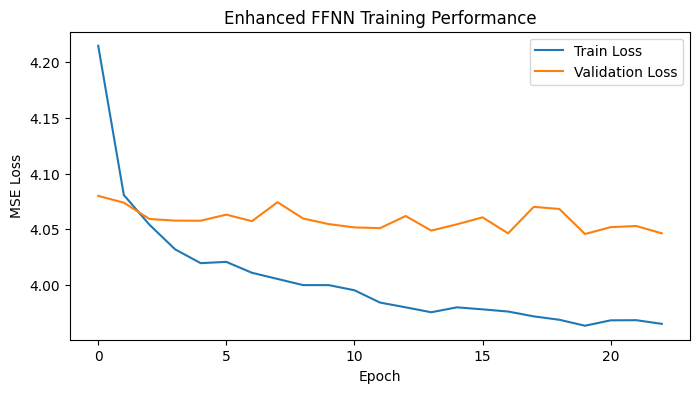

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Enhanced FFNN Training Performance")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
# plt.savefig("ffnn_training_performance.png", dpi=300, bbox_inches="tight")
plt.show()

In [126]:
# Save the full FFNN model
model.save("ffnn_model.keras")
print("✅ FFNN model saved as 'ffnn_model.keras'")

✅ FFNN model saved as 'ffnn_model.keras'


### XGBoost

In [127]:
import xgboost as xgb
# instatiate and train XGB Regressor
model_params = {"gamma": 0.42,
                "learning_rate": 0.047, 
                "max_depth": 4,
                "n_estimators": 171,
                "subsample": 0.6}

xg_reg = xgb.XGBRegressor(objective="reg:squarederror",
                          gamma=model_params['gamma'], 
                          learning_rate=model_params['learning_rate'], 
                          max_depth=model_params['max_depth'],
                          n_estimators=model_params['n_estimators'],
                          subsample=model_params['subsample'])

In [128]:
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.42, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.047, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=171, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [129]:
preds = xg_reg.predict(X_test)

In [130]:
mae_xgb = mean_absolute_error(y_test, preds)
mse_xgb = mean_squared_error(y_test, preds)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, preds)

print("\n✅ Final XGBoost Test Results:")
print(f"MAE: {mae_xgb:.3f}")
print(f"MSE: {mse_xgb:.3f}")
print(f"RMSE: {rmse_xgb:.3f}")
print(f"R²: {r2_xgb:.3f}")


✅ Final XGBoost Test Results:
MAE: 1.042
MSE: 4.033
RMSE: 2.008
R²: 0.321


In [131]:
xg_reg.save_model("xgb_model.json")
print("✅ XGBoost model saved as 'xgb_model.json'")

✅ XGBoost model saved as 'xgb_model.json'


## Model Explainability

In [138]:
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

### Random Forest

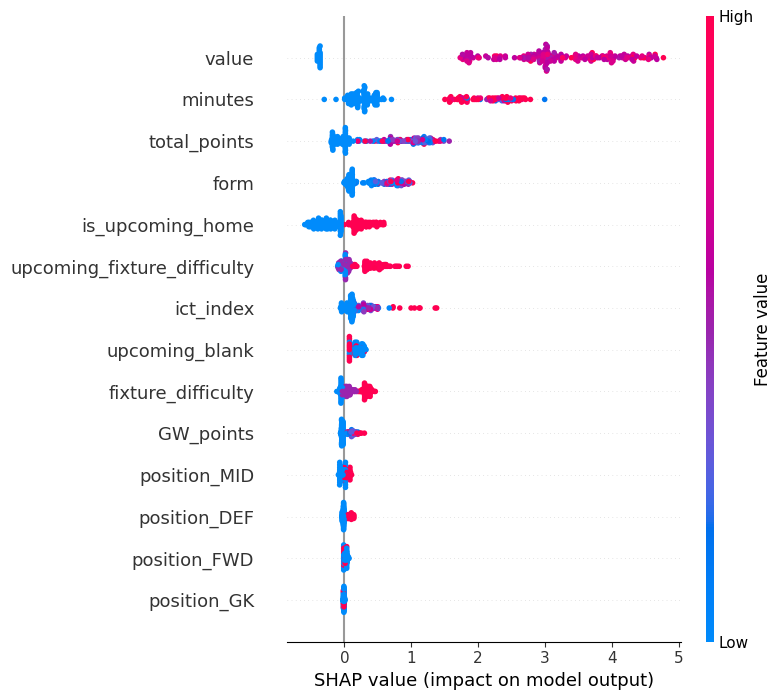

In [139]:
X_sample = X_test.sample(200, random_state=42)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols)

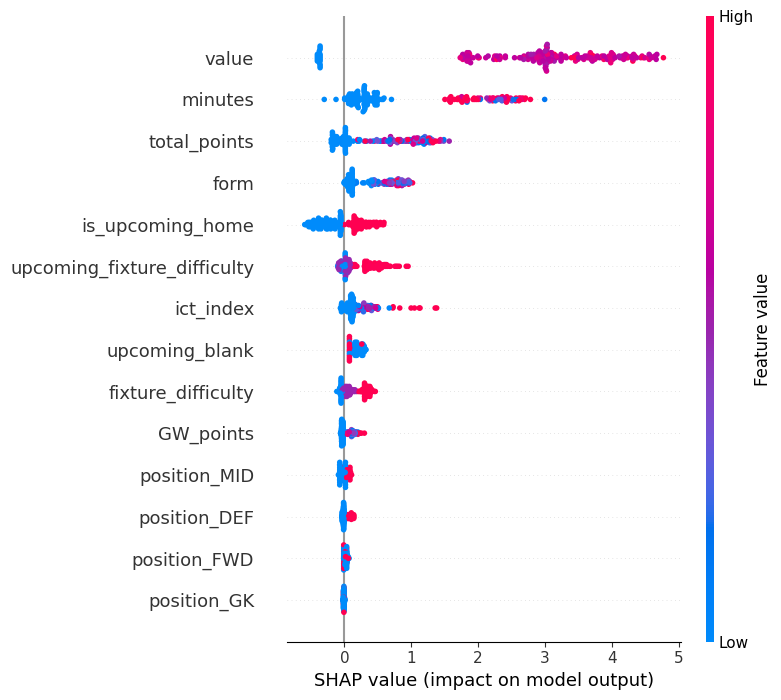

In [140]:
# shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False)
# fig = plt.gcf()
# fig.savefig('rf_shap_summary_plot.png', dpi=300, bbox_inches='tight')

In [141]:
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sample.iloc[0,:])

In [143]:
# shap.force_plot(
#     explainer.expected_value, 
#     shap_values[0,:], 
#     X_sample.iloc[0,:], 
#     matplotlib=True,        # <-- Crucial: Forces Matplotlib rendering
#     show=False              # <-- Prevents auto-display so we can save it
# )

# # 2. Save the figure to a file
# plt.gcf().savefig('rf_shap_force_plot_sample_0.png', dpi=300, bbox_inches='tight')

In [144]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_cols,
    mode='regression',
    discretize_continuous=True
)

In [148]:
i = 8
exp = explainer_lime.explain_instance(
    X_test.values[i],
    rf.predict,
    num_features=6
)

In [149]:
# exp.show_in_notebook() 

In [150]:
# exp.save_to_file('rf_lime_explanation_instance_8.html')

### FFNN

In [151]:
background = X_train.sample(50, random_state=42)
explainer_ffnn = shap.KernelExplainer(model.predict, background)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


In [152]:
X_sample = X_test.sample(10, random_state=42)
shap_values_ffnn = explainer_ffnn.shap_values(X_sample)

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


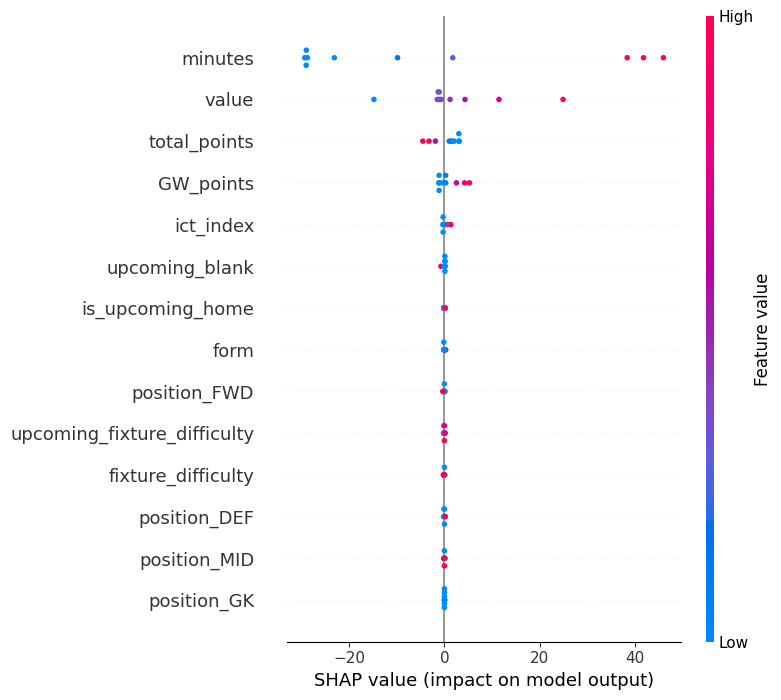

In [198]:
shap.summary_plot(shap_values_ffnn[0], X_sample, feature_names=feature_cols, plot_type="dot")

In [204]:
# shap.summary_plot(shap_values_ffnn, X_sample, feature_names=feature_cols, show=False)
shap.summary_plot(shap_values_ffnn[0], X_sample, feature_names=feature_cols, show=False, plot_type="dot")
fig = plt.gcf()
fig.savefig('nn_shap_summary_plot_dot.png', dpi=300, bbox_inches='tight')

In [156]:
# Handle both structures (list or array)
shap_values_array = shap_values_ffnn[0] if isinstance(shap_values_ffnn, list) else shap_values_ffnn

# Pick one example
i = 9

# Plot the single instance force plot
shap.force_plot(
    explainer_ffnn.expected_value,
    shap_values_array[i],
    X_sample.iloc[i],
    feature_names=feature_cols
)


In [157]:
shap.force_plot(
    explainer_ffnn.expected_value,
    shap_values_array[i],
    X_sample.iloc[i],
    feature_names=feature_cols,
    matplotlib=True,        # <-- Crucial: Forces Matplotlib rendering
    show=False              # <-- Prevents auto-display so we can save it
)

# 2. Save the figure to a file
plt.gcf().savefig('shap_force_plot_ffnn.png', dpi=300, bbox_inches='tight')

In [158]:
explainer_lime_ffnn = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_cols,
    mode='regression',
    discretize_continuous=True
)

In [161]:
i = 8
exp_ffnn = explainer_lime_ffnn.explain_instance(
    X_test.values[i],
    model.predict,   # FFNN’s prediction method
    num_features=6
)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [162]:
# exp_ffnn.show_in_notebook(show_table=True)

In [163]:
# exp_ffnn.save_to_file('nn_lime_explanation.html')

### XGBoost

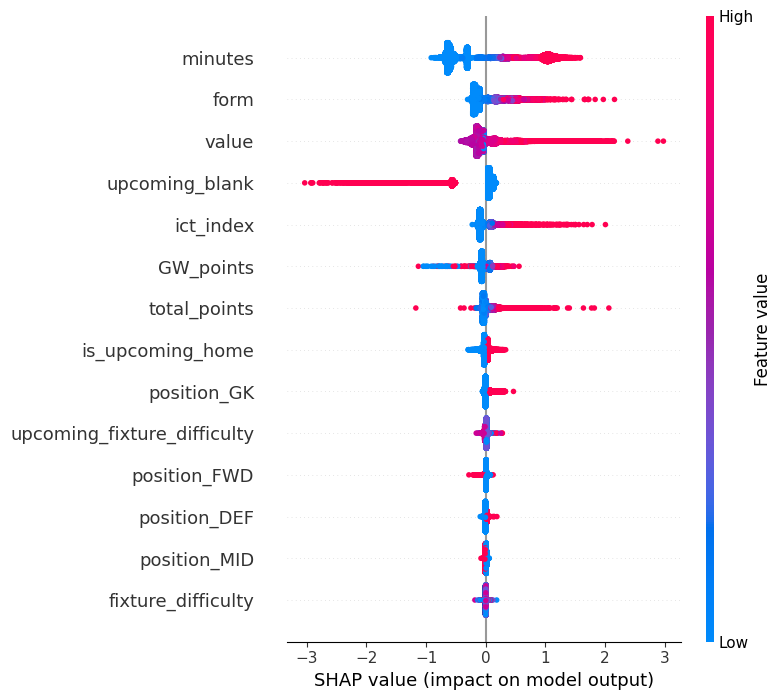

In [165]:
explainer_xgb = shap.TreeExplainer(xg_reg)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_cols)

In [166]:
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_cols, show=False)
fig = plt.gcf()
fig.savefig('xgb_shap_summary_plot.png', dpi=300, bbox_inches='tight')

In [185]:
i = 19
shap.force_plot(
    explainer_xgb.expected_value, 
    shap_values_xgb[i, :], 
    X_test.iloc[i, :]
)

In [178]:
i = 9
shap.force_plot(
    explainer_xgb.expected_value, 
    shap_values_xgb[i, :], 
    X_test.iloc[i, :],
    matplotlib=True,
    show=False
)

# 2. Save the figure to a file
plt.gcf().savefig('xgb_shap_force_plot.png', dpi=300, bbox_inches='tight')

In [179]:
explainer_lime_xgb = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_cols,
    mode='regression',
    discretize_continuous=True
)

In [186]:
i = 19
exp_xgb = explainer_lime_xgb.explain_instance(
    X_test.values[i],
    xg_reg.predict,
    num_features=6
)

In [187]:
exp_xgb.show_in_notebook(show_table=True)

In [188]:
exp_xgb.save_to_file('xgb_lime_explanation.html')

## Visualisations

In [94]:
X_all_scaled = scaler.transform(X)

# -----------------------------
# 2️⃣ Predict for the entire dataset
# -----------------------------
preds = model.predict(X_all_scaled)

2981/2981 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [97]:
cleaned_df = cleaned_df.drop(columns=['Actual Points', 'Predicted Points'], errors='ignore')

# ✅ Create a dataframe aligned with test indices
results_df = pd.DataFrame({
    'Actual Points': y,
    'Predicted Points': np.rint(preds).astype(int).flatten()
}, index=y.index)

# ✅ Attach results to the main cleaned_df using index alignment
cleaned_df = cleaned_df.join(results_df, how='left')

                 name   season  Actual Points  Predicted Points
81708  Erling Haaland  2022-23            5.0               5.0
81709  Erling Haaland  2022-23            6.0               5.0
81710  Erling Haaland  2022-23           17.0               5.0
81711  Erling Haaland  2022-23           17.0               6.0
81712  Erling Haaland  2022-23            9.0               6.0


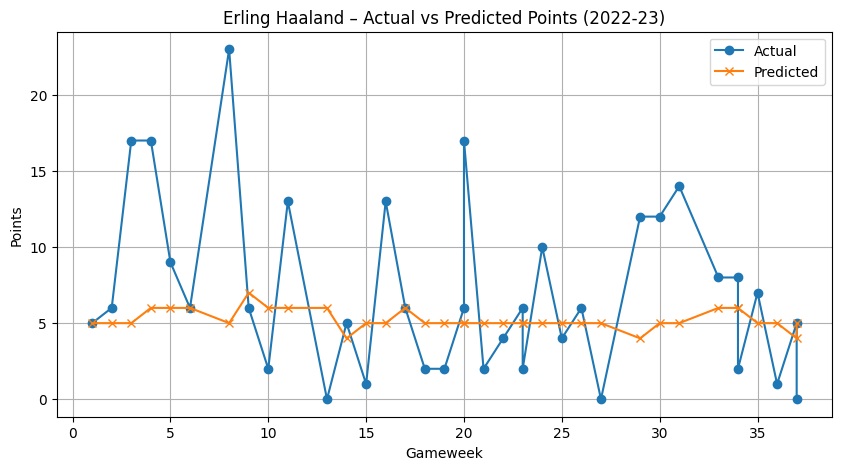

In [99]:

# Example: filter results for a specific player and season
player_name = "Erling Haaland"
season = "2022-23"

player_data = cleaned_df[
    (cleaned_df["name"] == player_name) &
    (cleaned_df["season"] == season)
].dropna(subset=["Predicted Points", "Actual Points"])

# Display first few rows
print(player_data[["name", "season", "Actual Points", "Predicted Points"]].head())

# Optional: visualize predicted vs actual for this player
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(player_data["GW"], player_data["Actual Points"], label="Actual", marker='o')
plt.plot(player_data["GW"], player_data["Predicted Points"], label="Predicted", marker='x')
plt.title(f"{player_name} – Actual vs Predicted Points ({season})")
plt.xlabel("Gameweek")
plt.ylabel("Points")
plt.legend()
plt.grid(True)
plt.show()


In [89]:
# 6️⃣ Evaluate for that player only
mae_p = mean_absolute_error(player_data['Actual Points'], player_data['Predicted Points'])
r2_p = r2_score(player_data['Actual Points'], player_data['Predicted Points'])

print(f"\n📊 {player_name} ({season}) Performance:")
print(f"MAE: {mae_p:.3f}")
print(f"R²: {r2_p:.3f}")


📊 Patrick Bamford (2022-23) Performance:
MAE: 1.992
R²: -0.372
